In [1]:
import numpy as np

import scipy.optimize
import sys
import matplotlib.pyplot as plt

In [2]:
class Constants(object):
    def __init__(self):
        # Overall process variables:
        # A : Strongly adsorbing component
        # Binary mixture
        #Temperatures
        self.T_H = 421.34 # [K] # Desorption Temperature
        self.T_C = 303.02 # [K] # Adsorption Temperature
        self.n_steps = 50
        self.delta_T_k = (self.T_H-self.T_C) / self.n_steps
        
        # Feed composition 
        self.y_A_feed = 0.12 # molefraction
        self.y_B_feed = 1 - self.y_A_feed
        # pressures:
        self.p_tot = 1.3 #bar #isobaric conditions
        self.p_tot_Pa = self.p_tot * 10**5 #Pascal
        self.p_A_feed = self.y_A_feed * self.p_tot # Partial pressure of A in the feed # [bar]
        self.p_B_feed = self.y_B_feed * self.p_tot
        # Mass of adsorbent in column:
        self.m_ads = 1 # [kg]
        # Densities:
        self.rho_bed_X13 = 708 # Kg / m^3 # Bed density
        self.rho_particle_X13 = 1085 # Kg / m^3 # Density of the pure zeolite
        self.porosity = 1 - (self.rho_bed_X13 / self.rho_particle_X13)
        # volume of the column:
        self.volume = self.m_ads / self.rho_bed_X13
        
#        l_col = 1.2 #meter
#        internal_d_col = 3 * 10**(-2) #meter
#        v_col = l_col * np.pi * (internal_d_col/2)**2
#        v_particle = 1/self.rho_particle_X13
#        v_bed = 1/self.rho_bed_X13
        
        self.c_p_ads = 920 # J /kg / K # specific heat capacity for zeolite 13X
        self.R = 8.314          # [J/mol/K]
        
consts = Constants()

## Isosteric heats of adsorption
### $\Delta H_{is,A} = \frac{RT^2}{P_A} \frac{\big(\frac{\partial n_A}{\partial P_B}\big)   \big(\frac{\partial n_B}{\partial T}\big)   - \big(\frac{\partial n_A}{\partial T}\big)   \big(\frac{\partial n_B}{\partial P_B}\big)}  
{\big(\frac{\partial n_A}{\partial P_A}\big)   \big(\frac{\partial n_B}{\partial P_B}\big)   - \big(\frac{\partial n_A}{\partial P_B}\big)   \big(\frac{\partial n_B}{\partial P_A}\big)}$
### $\Delta H_{is,B} = \frac{RT^2}{P_B} \frac{\big(\frac{\partial n_B}{\partial P_A}\big)   \big(\frac{\partial n_A}{\partial T}\big)   - \big(\frac{\partial n_B}{\partial T}\big)   \big(\frac{\partial n_B}{\partial P_A}\big)}  
{\big(\frac{\partial n_B}{\partial P_B}\big)   \big(\frac{\partial n_A}{\partial P_A}\big)   - \big(\frac{\partial n_B}{\partial P_A}\big)   \big(\frac{\partial n_A}{\partial P_B}\big)}$

Compare S2 <br />
solve with central difference approximation

In [3]:
### TODO
# def isosteric_heats():
#     #just example values
#     T = 10
#     T_1 = 10
#     T_2 = 20
#     p_A = 1
#     p_A_1 = 10
#     p_A_2 = 20
#     p_B = 1
#     p_B_1 = 10
#     p_B_2 = 20
#     n_A_1 = 1
#     n_A_2 = 2
#     n_B_1 = 1
#     n_B_2 = 2
# 
#     delta_T = T_2 - T_1
#     delta_p_A = p_A_2 - p_A_1
#     delta_p_B = p_B_2 - p_B_1
#     delta_n_A = n_A_2 - n_A_1
#     delta_n_B = n_B_2 - n_B_1
# 
#     delta_h_A = (R * T**2) / (p_A) * ((delta_n_A / delta_p_B) * (delta_n_B / delta_T) - (delta_n_A / delta_T) * (delta_n_B / delta_p_B)) / ((delta_n_A / delta_p_A) * (delta_n_B / delta_p_B) - (delta_n_A / delta_p_B) * (delta_n_B / delta_p_A)) 
# 
#     delta_h_B = (R * T**2) / (p_B) * ((delta_n_B / delta_p_A) * (delta_n_A / delta_T) - (delta_n_B / delta_T) * (delta_n_A / delta_p_A)) / ((delta_n_B / delta_p_B) * (delta_n_A / delta_p_A) - (delta_n_B / delta_p_A) * (delta_n_A / delta_p_B)) 
#     
#     return delta_h_A, delta_h_B

In [4]:
# SIPS isotherm for Zeolite X13 see SI
class Iso_mod(object):
    def __init__(self):
        # Parameters
        # components:
        # 1 A = CO2
        # 2 B = N2
        # adsorbent: ZEOLITE 13X --> Type FAU zeolite
        self.T_ref = 298        # [K]
        self.T_ref_A = self.T_ref    # [K]
        self.T_ref_B = self.T_ref    # [K]
        self.a_A = 0.72378      # [-]
        self.a_B = 0.0          # [-]
        self.c_ref_A = 0.42456  # [-]
        self.c_ref_B = 0.98624  # [-]
        self.Q_b_A = 28389      # [J / mol ]
        self.Q_b_B = 18474      # [J / mol ]
        self.b0_A = 1.129e-4    # [bar]
        self.b0_B = 5.8470e-5   # [bar]
        self.x_A = -0.61684     # [-]
        self.x_B = 0.0          # [-]
        self.n_inf_ref_A = 7.268# [mol/kg]
        self.n_inf_ref_B = 4.051# [mol/kg]
        # Temperature dependent parameters calculate via update_T_dep_params(self, T)
        self.n_ads_inf_A = 0
        self.n_ads_inf_B = 0
        self.T = 0
        self.b_A = 0
        self.b_B = 0
        self.c_A = 0 
        self.c_B = 0
        
    def update_T_dep_params(self, T):
        self.T = T
        # Temperature dependence of saturation capacity
        self.n_ads_inf_A = self.n_inf_ref_A * np.exp(self.x_A * ((self.T/self.T_ref_A)-1))
        self.n_ads_inf_B = self.n_inf_ref_B * np.exp(self.x_B * ((self.T/self.T_ref_B)-1))
        # Temperature dependence of affinity parameter
        self.b_A = self.b0_A * np.exp(self.Q_b_A/(consts.R*T))
        self.b_B = self.b0_B * np.exp(self.Q_b_B/(consts.R*T))
        # Temperature dependence of heterogeneity parameter
        self.c_A = self.c_ref_A + self.a_A*((T/self.T_ref)-1)
        self.c_B = self.c_ref_B + self.a_B*((T/self.T_ref)-1)
    
    def print_T_dep_params(self):
        print('n_ads_inf_A:{:6.4f}'.format(self.n_ads_inf_A))
        print('b_A:{:6.4f}'.format(self.b_A))
        print('c_A:{:6.4f}'.format(self.c_A))
        print('n_ads_inf_B:{:6.4f}'.format(self.n_ads_inf_B))
        print('b_B:{:6.4f}'.format(self.b_B))
        print('c_B:{:6.4f}'.format(self.c_B))
        
iso = Iso_mod()

In [5]:
def loading_for_T(y_A):
    # A = CO2; B = N2
    # extendet Sips isotherm modell
    # T_dependend parameters have to be updated
    y_B = 1 - y_A
    n_ads_A = (iso.n_ads_inf_A * (iso.b_A * consts.p_tot * y_A)**iso.c_A) / (1 + (iso.b_A * consts.p_tot * y_A)**iso.c_A + (iso.b_B * consts.p_tot * y_B)**iso.c_B)
    n_ads_B = (iso.n_ads_inf_B * (iso.b_B * consts.p_tot * y_B)**iso.c_B) / (1 + (iso.b_A * consts.p_tot * y_A)**iso.c_A + (iso.b_B * consts.p_tot * y_B)**iso.c_B)
    return n_ads_A, n_ads_B # [mol/kg]

# Stoffmenge im Gas im Adsorber
def N_gas(y, T):
    ngas = ((consts.porosity * y * consts.p_tot_Pa * consts.volume) / (consts.R * T))
    return ngas

# Equations heating step:
def heating_step(estimates, *args):
    N_A_ads_kmo, N_B_ads_kmo, N_gas_A_kmo, N_gas_B_kmo, T_k = args[0]
    (N_out, y_A_k) = estimates # estimates for y_A_k and N_out_k
    y_B_k = 1 - y_A_k
    eqn_1 = N_A_ads_kmo + N_gas_A_kmo - y_A_k * N_out - loading_for_T(y_A_k)[0] - N_gas(y_A_k, T_k) # passen die Einheiten hier (besondere fürs Loading) --> hier fehlt ein mads, aber das sollte keinen Unterschied machen, da m=1
    eqn_2 = N_B_ads_kmo + N_gas_B_kmo - y_B_k * N_out - loading_for_T(y_A_k)[1] - N_gas(y_B_k, T_k)
    return [eqn_1, eqn_2]

In [6]:
# Heating step 
#initial conditions

y_A_kmo = consts.y_A_feed
y_B_kmo = 1 - y_A_kmo
T_k = consts.T_C
T_kmo = consts.T_C
iso.update_T_dep_params(consts.T_C)
N_A_ads_kmo, N_B_ads_kmo = consts.m_ads * loading_for_T(consts.y_A_feed)
N_gas_A_kmo, N_gas_B_kmo = N_gas(y_A_kmo, T_k), N_gas(y_B_kmo, T_k)
N_out = 0.332 # estimate
# lists to store outputs
y_As, temperatures, N_outs = [], [], []
y_As.append(consts.y_A_feed)
temperatures.append(consts.T_C)

Step:   1 y_A_kmo: 0.12 y_A_k: 0.13 N_out_k:0.014608 T_K: 305.4
Step:   2 y_A_kmo: 0.13 y_A_k: 0.14 N_out_k:0.014053 T_K: 307.8
Step:   3 y_A_kmo: 0.14 y_A_k: 0.16 N_out_k:0.013553 T_K: 310.1
Step:   4 y_A_kmo: 0.16 y_A_k: 0.17 N_out_k:0.013104 T_K: 312.5
Step:   5 y_A_kmo: 0.17 y_A_k: 0.19 N_out_k:0.012706 T_K: 314.9
Step:   6 y_A_kmo: 0.19 y_A_k: 0.20 N_out_k:0.012357 T_K: 317.2
Step:   7 y_A_kmo: 0.20 y_A_k: 0.22 N_out_k:0.012057 T_K: 319.6
Step:   8 y_A_kmo: 0.22 y_A_k: 0.24 N_out_k:0.011805 T_K: 322.0
Step:   9 y_A_kmo: 0.24 y_A_k: 0.26 N_out_k:0.011602 T_K: 324.3
Step:  10 y_A_kmo: 0.26 y_A_k: 0.28 N_out_k:0.011449 T_K: 326.7
Step:  11 y_A_kmo: 0.28 y_A_k: 0.30 N_out_k:0.011346 T_K: 329.1
Step:  12 y_A_kmo: 0.30 y_A_k: 0.33 N_out_k:0.011297 T_K: 331.4
Step:  13 y_A_kmo: 0.33 y_A_k: 0.36 N_out_k:0.011305 T_K: 333.8
Step:  14 y_A_kmo: 0.36 y_A_k: 0.38 N_out_k:0.011375 T_K: 336.1
Step:  15 y_A_kmo: 0.38 y_A_k: 0.41 N_out_k:0.011514 T_K: 338.5
Step:  16 y_A_kmo: 0.41 y_A_k: 0.45 N_ou

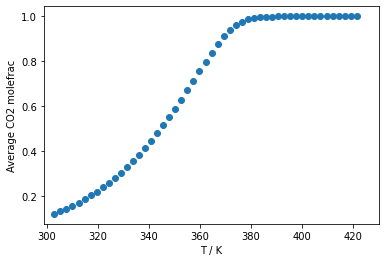

In [7]:
# do the single steps
for i in range(0, consts.n_steps):
    T_k += consts.delta_T_k
    iso.update_T_dep_params(T_k)
    #iso.print_T_dep_params()
    inp_vars = [N_A_ads_kmo, N_B_ads_kmo, N_gas_A_kmo, N_gas_B_kmo, T_k]
    estimates = (N_out, y_A_kmo) # faösch rum
    
    # Solver
    # ‘hybr’ , ‘lm’, ‘broyden1’, ‘broyden2’, ‘anderson’, ‘linearmixing’, ‘diagbroyden’, ‘excitingmixing’, ‘krylov’, ‘df-sane’
    x = scipy.optimize.root(heating_step, x0 = estimates, args = inp_vars, method = 'hybr')
    # y_A_k, N_out = x['x']
    N_out, y_A_k = x['x']
    y_B_k = 1 - y_A_k
    print('Step: {:>3} y_A_kmo: {:4.2f} y_A_k: {:4.2f} N_out_k:{:8.6f} T_K: {:4.1f}'.format(i+1, y_A_kmo, y_A_k, N_out, T_k))
    
    # read results and calculate new values
    N_A_ads_kmo, N_B_ads_kmo = loading_for_T(y_A_k)
    N_gas_A_kmo = N_gas(y_A_k , T_k)
    N_gas_B_kmo = N_gas(y_B_k , T_k)
    T_kmo = T_k
    y_A_kmo = y_A_k
    
    #store calculated values
    N_outs.append(N_out)
    y_As.append(y_A_k)
    temperatures.append(T_k)

plt.scatter(temperatures, y_As)
plt.xlabel('T / K')
plt.ylabel('Average CO2 molefrac')
plt.xlim(299,430)
plt.show()

In [8]:
###### calculate product purity and working capacity        ### ADD Specific Energy
N_out_A = 0
for y_A, N_out in zip(y_As, N_outs):
    N_out_A += (y_A * N_out)
prod_purity = N_out_A / sum(N_outs)
working_capacity = N_out_A / consts.m_ads
print('Product purity: {:5.3f}'.format(prod_purity))
print('Working capacity: {:5.2f}'.format(working_capacity))
print('Paper: WC = 1.63, y_co2 = 0.89')
    
# delta_N_A_ads_k = N_A_ads_k - N_A_ads_kmo
# delta_N_A_ads_k = N_B_ads_k - N_B_ads_kmo
# Q_ext_k = m_ads * c_p_ads * delta_T_k - delta_H_is_A_k * delta_N_A_ads_k - delta_H_is_B_k * delta_N_B_ads_k

Product purity: 0.871
Working capacity:  1.54
Paper: WC = 1.63, y_co2 = 0.89


In [9]:
iso.update_T_dep_params(consts.T_C)
N_A_ads_start = consts.m_ads * loading_for_T(consts.y_A_feed)[0]
N_B_ads_start = consts.m_ads * loading_for_T(consts.y_A_feed)[1]
iso.update_T_dep_params(consts.T_H)
N_A_ads_end = consts.m_ads * loading_for_T(0.98)[0]
N_B_ads_end = consts.m_ads * loading_for_T(0.98)[1]
#Estimate of the working capacity
print(N_A_ads_start + N_gas(consts.y_A_feed , consts.T_C) - N_A_ads_end - N_gas(0.89, consts.T_H))
print(N_B_ads_start + N_gas(1-consts.y_A_feed , consts.T_C) - N_B_ads_end - N_gas(1-0.89, consts.T_H))
print(1.66/50) # average N_out_k

1.5798959480769625
0.20901188722020014
0.0332
